# Collaboration and Competition

---

You are welcome to my coding environment for multi agent train for the Udacity project of Collaboration and Competition. The aim of the code is to train a competing agents playing in the a simple Unity enviroment of a tennis court.

Follow the instructions below to get started!


The first step makes available some utility libreries used throughout the Notebook.

In [1]:
import numpy as np
from utilities import Plotting
import random
import torch
from collections import namedtuple, deque
import progressbar as pb

### 1. Start the Environment

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. State and Action Spaces

The code in the cell below prints some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
print(type(states))
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
<class 'numpy.ndarray'>
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Random Actions in the Environment to Initialize the Replay Buffer

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
from replay_buffer import ReplayBuffer

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

buffer_size = 15000
batch_size = 256 

replay_buffer = ReplayBuffer(device, buffer_size, batch_size)

widget = ['Buffer fillup: ', pb.Percentage(), ' ',pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=buffer_size).start()

for i in range(buffer_size):
    actions =  (np.random.rand(action_size,action_size)*2)-1 # btwn -1..1
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    
    replay_buffer.add(states.shape[0], actions.shape[0], np.max(rewards), next_states.shape[0], np.max(dones))
    states = next_states
    timer.update(i+1)
    
    if True in dones:
        env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations

timer.finish()


Buffer fillup: 100% |###########################################| Time: 0:00:25


### 4. Agent and Hyperparameters

The agent class is coded in the `my_agent.py` file.

In [6]:
from agent_jn import Agent
from model import Actor, Critic

# The agent implementation is common and use the experiance of both the two tennis players
state_size = state_size*num_agents
action_size = action_size*num_agents

# agent
agent = Agent(
    state_size, action_size, Actor, Critic,
    lrate_critic=1e-3,
    lrate_actor=1e-4,
    tau=0.01,
    buffer_size=1e6,
    batch_size=256,
    gamma=0.99,
    exploration_mu=0.0,
    exploration_theta=0.15,
    exploration_sigma=0.20,
    seed=np.random.randint(1000),
    update_every=1, 
    update_repeat=1,
    weight_decay=0, 
    noise_decay=0.99995
)

print('Running on: ' + device)

Running on: cpu


### 5. It's Turn of Train the Agent

Now it's your turn to train the agent to solve the environment!  The enviroment is considered solved when the agent achieves an avarage score of 0.5 points over 100 episodes.
While training the agent, you can see the progress in an online tred.

The training follow few main steps, for each episode:
- the actor model of the agent run actions on the enviroment with some added noise to ensure exploration. The `OUNoise` Class is used for this purpose.
- additional informations from the enviroment are retrieved after the action of the agent (reward, next_state, etc.) and are piled into the **Replay Buffer**. 
- experiances are extracted from the **Replay Buffer** and used to:
    - calculate the TD target
    - soft-update the critic model
    - soft-update the actor model
- The results are collected and showed and if the avarage score passes the 0.5 points and improve from the previous episodes, the models are checkpointed.
- At the end of the training the trend with the progress is saved in the folder `Results\`.

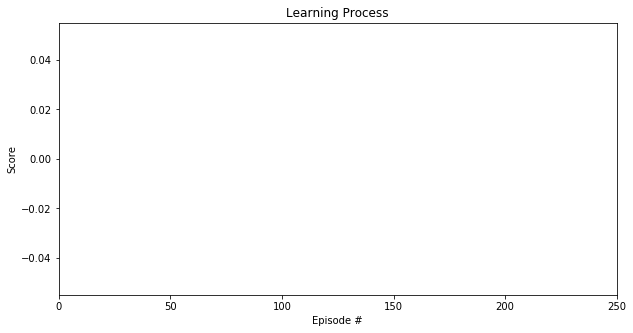

TypeError: expected np.ndarray (got int)

In [7]:
episodes = 2000
steps = 2000

scores = deque(maxlen=100)
PScores = []

# Score Trend Initializaiton
plot = Plotting(
    title ='Learning Process',
    y_label = 'Score',
    x_label = 'Episode #',
    x_range = 250,
)
plot.show()

# Progress bar o terminal
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

# writer = SummaryWriter()
last_saved = 0
for episode in range(episodes):
    
    # Reset the OUNoise state
    agent.reset_episode()
    
    # Enviroment initialization and initial state
    env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    
    score = np.zeros(num_agents)
    for step_i in range(steps):
        
        # Agent Interact with the enviroment
        action = agent.act(states.shape[0])
        
        # Enviroment response
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        #####next_state, reward, done = env.step(action.reshape(2,-1))
        
        # Interactions are collected in the replay buffer
        replay_buffer.add(states.shape[0], actions.shape[0], np.max(rewards), next_states.shape[0], np.max(dones))
        
        
        # Agent learn step
        agent.learn_step(states.shape[0], actions.shape[0], np.max(rewards), next_states.shape[0], np.max(dones))
        
        # Shift to next experiance step
        states = next_states
        score += rewards                     # Episode score builtup
        
        # Episode end condition
        if done.any():
            break
    # collect  episode results
    scores.append(score.max())
    mean = np.sum(scores)/100
    if (episode+1)%50 ==0 :
        print("Episode: {0:d}, Score: {1:f}".format(episode+1,mean))
    timer.update(episode+1)
    #summary = f'Episode: {episode+1}/{episodes}, Steps: {agent.it:d}, Noise: {agent.noise_scale:.2f}, Score Agt. #1: {score[0]:.2f}, Score Agt. #2: {score[1]:.2f}'
    PScores.append(mean)
    plot.Update(list(range(episode+1)),PScores)
    #summary += f', Score: {mean:.3f}'
    # writer.add_scalar('data/score', mean, ep_i)
    if mean > 0.50 and mean > last_saved:
        last_saved = mean
        agent.save('saved/trained_model.ckpt')
    
timer.finish()

# Save Training Trend
end_plot = Plotting(
    title ='Learning Process',
    y_label = 'Score',
    x_label = 'Episode #',
    x_values = list(range(episode-(100-2))),
    y_values = PScores
)
end_plot.save('Results/Training.png')


### 6. See the Agent Performs!

Now that the agent is trained you can see it in action!

After loading the checkpoint an episode is run.